Welcome to the 30 minutes Flower federated learning tutorial!

In this tutorial you will implement your first Federated Learning project using [Flower](https://flower.ai/). You can find a similar tutorial, but using the preferred `flwr run` CLI command to launch your experiments in [the Flower Documentation](https://flower.ai/docs/framework/tutorial-quickstart-pytorch.html).

🧑‍🏫 This tutorial starts at zero and expects no familiarity with federated learning. Only a basic understanding of data science and Python programming is assumed. A minimal understanding of ML is not required but if you already know about it, nothing is stopping your from modifying this code as you see fit!

> [Star Flower on GitHub](https://github.com/adap/flower) ⭐️ and join the Flower community on Flower Discuss and the Flower Slack to connect, ask questions, and get help:
> - [Join Flower Discuss](https://discuss.flower.ai/) We'd love to hear from you in the `Introduction` topic! If anything is unclear, post in `Flower Help - Beginners`.
> - [Join Flower Slack](https://flower.ai/join-slack) We'd love to hear from you in the `#introductions` channel! If anything is unclear, head over to the `#questions` channel.

Let's get started!

# Environment Setup

Now let's really begin with this tutorial!

To start working with Flower, very little is required once you have activated your Python environment (e.g. via `conda`, `virtualenv`, `pyenv`, etc). If you are running this code on Colab, there is really nothing to do except to install Flower and other dependencies. The steps below have been verified to run in Colab. Let's first, install Flower, then the ML framework of your choice and extra dependencies you might want to use.

## Installing Flower

You can install flower very conveniently from `pip`:

In [13]:
!pip install -q "flwr[simulation]" flwr-datasets

We will be using the _simulation_ engine in Flower, which allows you to run a large number of clients without the overheads of manually managing devices. This is achieved via the `Simulation Engine`, the core component in Flower to run simulations efficiently.

## Install your ML framework

Flower is agnostic to your choice of ML Framework. Flower works with `PyTorch`, `Tensorflow`, `NumPy`, `🤗 Transformers`, `MLX`, `JAX`, `scikit-learn`, `fastai`, `Pandas`. Flower also supports all major platforms: `iOS`, `Android` and plain `C++`. You can find a _quickstart- example for each of the above in the [Flower Repository](https://github.com/adap/flower/tree/main/examples) inside the `examples/` directory. And check the [Flower Documentation](https://flower.ai/docs/) for even more learning materials.

In this tutorial we are going to use PyTorch, uncomment the line below if you haven't installed PyTorch in your system. In this tutorial we'll use a small model so using CPU only training will suffice.

In [14]:
# you might see a warning after running the command below, this can be ignored
# if you are running this outside Colab, you probably need to adjust the command below
# !pip install torch==1.13.1+cpu torchvision==0.14.1+cpu --extra-index-url https://download.pytorch.org/whl/cpu

We are going to install some other dependencies you are likely familiar with. We'll use these to make plots.

In [15]:
!pip install matplotlib

# Centralised training: the old way of doing ML

Let's begin by creating a simple (but complete) training loop as it is commonly done in centralised setups. Starting our tutorial in this way will allow us to very clearly identify which parts of a typical ML pipeline are common to both centralised and federated training and which ones are poles a part.

For this tutorial we'll design a image classification pipeline for [MNIST digits](https://en.wikipedia.org/wiki/MNIST_database) and using a simple CNN model as the network to train. The MNIST dataset is comprised of `28x28` greyscale images with digits from 0 to 9 (i.e. 10 classes in total)


## A dataset

Let's begin by constructing the dataset. We will use 🤗HuggingFace Datasets to download MNIST. We will prepare a function that will be use later to apply standard normalization transformations from `TorchVision` and create the dataloaders for the `train` and `test` partitions.

In [16]:
# we naturally first need to import torch and torchvision
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
from datasets import load_dataset


def get_mnist_dataloaders(mnist_dataset, batch_size: int):
    pytorch_transforms = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])

    # Prepare transformation functions
    def apply_transforms(batch):
        batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
        return batch

    mnist_train = mnist_dataset["train"].with_transform(apply_transforms)
    mnist_test = mnist_dataset["test"].with_transform(apply_transforms)

    # Construct PyTorch dataloaders
    trainloader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(mnist_test, batch_size=batch_size)
    return trainloader, testloader


# Download dataset
mnist = load_dataset("ylecun/mnist")
# mnist = load_dataset("fashion_mnist")
# mnist = load_dataset("ag_news")


We can have a quick overview of our datasets by just typing the object on the command line. For instance, below you can see the sizes of both the `train` and `test` partitions

In [17]:
mnist


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

Let's create a more insightful visualisation. First let's see the distribution over the labels by constructing a histogram. Then, let's visualise some training examples !

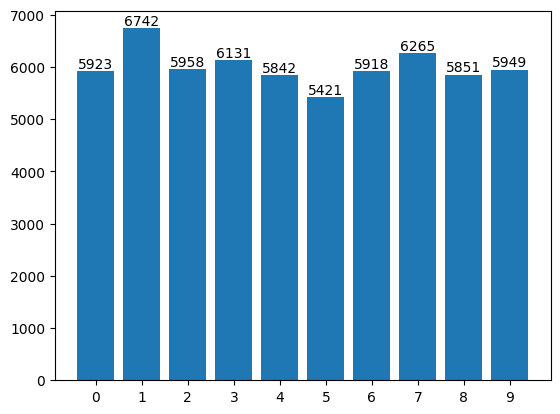

In [18]:
import matplotlib.pyplot as plt
from collections import Counter


# construct histogram
all_labels = mnist["train"]["label"]
all_label_counts = Counter(all_labels)

# visualise histogram
bar = plt.bar(all_label_counts.keys(), all_label_counts.values())
_ = plt.bar_label(bar)

# plot formatting
_ = plt.xticks([label for label in all_label_counts.keys()])

Let's visualise 32 images from the dataset


In [19]:
import random
import numpy as np
from PIL import Image
import io


def visualise_n_random_examples(trainset_, n: int, verbose: bool = True):
    trainset_data = [
        Image.open(io.BytesIO(entry[0].as_py())) for entry in trainset_.data[0]
    ]
    idx = list(range(len(trainset_data)))
    random.shuffle(idx)
    idx = idx[:n]
    if verbose:
        print(f"will display images with idx: {idx}")

    # construct canvas
    num_cols = 8
    num_rows = int(np.ceil(len(idx) / num_cols))
    fig, axs = plt.subplots(figsize=(16, num_rows * 2), nrows=num_rows, ncols=num_cols)

    # display images on canvas
    for c_i, i in enumerate(idx):
        axs.flat[c_i].imshow(trainset_data[i], cmap="gray")

will display images with idx: [37938, 41049, 41687, 55754, 57606, 36987, 2988, 26390, 48467, 3853, 10281, 56938, 17887, 9494, 5672, 14609, 17287, 27654, 41652, 23979, 3323, 41091, 35607, 1025, 31313, 25198, 47632, 28447, 42782, 2214, 14769, 23567]


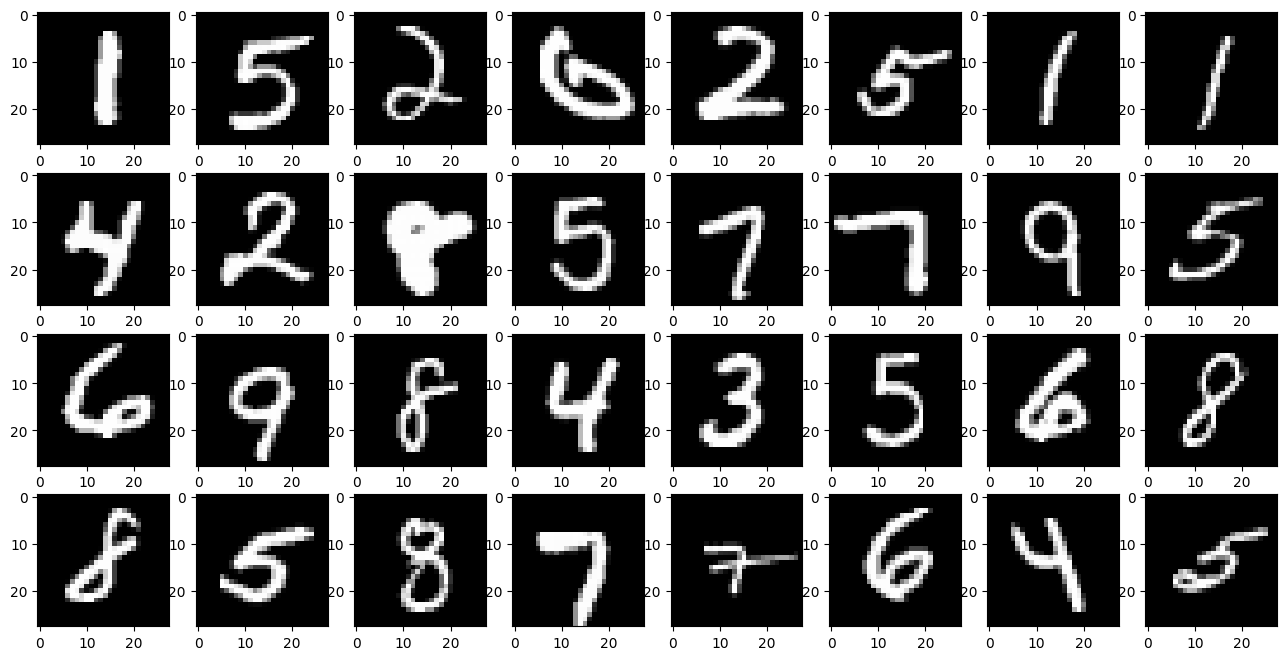

In [20]:
# it is likely that the plot this function will generate looks familiar to other plots you might have generated before
# or you might have encountered in other tutorials. So far, we aren't doing anything new, Federated Learning will start soon!
visualise_n_random_examples(mnist["train"], n=32)



# A CNN architecture

This tutorial is not so much about novel architectural designs so we keep things simple and make use of a typical CNN that is adequate for the MNIST image classification task.



In [21]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Similarly to what we did with the dataset you could inspect the model in various ways. We can, for instance, count the number of model parameters.

#### initialize the weight randomly (i think?)

In [22]:
model = Net(num_classes=10)
num_parameters = sum(value.numel() for value in model.state_dict().values())
print(f"{num_parameters = }")

# print the model's weight
for name, param in model.named_parameters():
    print(f"{name}:\n{param.data[:10]}")  # Prints first 5 values

num_parameters = 44426
conv1.weight:
tensor([[[[-0.1947,  0.0262,  0.0752, -0.1605,  0.1501],
          [-0.1188, -0.1750, -0.0945,  0.0769,  0.0460],
          [ 0.0041, -0.1437,  0.0733, -0.1488, -0.0179],
          [ 0.0567,  0.1060,  0.0453, -0.0090, -0.0542],
          [ 0.0159,  0.0450,  0.0334,  0.0773,  0.1458]]],


        [[[-0.0759,  0.1728, -0.1348,  0.0161,  0.1796],
          [-0.0737, -0.1600,  0.1292,  0.1318, -0.0958],
          [-0.0702, -0.1471, -0.1795,  0.1648,  0.0742],
          [ 0.1326,  0.1126, -0.0594, -0.0018,  0.1701],
          [-0.1051,  0.1380,  0.0379, -0.1878, -0.1513]]],


        [[[ 0.0323, -0.0107,  0.1123,  0.1317,  0.0120],
          [-0.1120, -0.0518,  0.1781, -0.0134, -0.0571],
          [ 0.1754,  0.1387, -0.1241,  0.1407, -0.0739],
          [-0.1591,  0.0031,  0.1711, -0.1314,  0.1288],
          [-0.1731,  0.1156,  0.0767,  0.1003, -0.0020]]],


        [[[-0.0782,  0.1916,  0.0267,  0.1463,  0.0552],
          [ 0.1099,  0.0778, -0.1029,  

## The Training Loop

A minimal training loop in PyTorch can be constructed with three functions:
*  `train()` that will train the model given a dataloader.
* `test()` that will be used to evaluate the performance of the model on held-out data, e.g., a training set.
* `run_centralised()` which will define additional elements (e.g. the optimiser) and run the training loop over N epochs.

Let's construct these functions!


In [23]:
def train(net, trainloader, optimizer, device="cpu"):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    net.to(device)
    net.train()
    for batch in trainloader:
        images, labels = batch["image"].to(device), batch["label"].to(device)
        optimizer.zero_grad()
        loss = criterion(net(images), labels)
        loss.backward()
        optimizer.step()


def test(net, testloader, device):
    """Validate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, loss = 0, 0.0
    net.to(device)
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["image"].to(device), batch["label"].to(device)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    accuracy = correct / len(testloader.dataset)
    return loss, accuracy


def run_centralised(
    trainloader, testloader, epochs: int, lr: float, momentum: float = 0.9
):
    """A minimal (but complete) training loop"""

    # instantiate the model
    model = Net(num_classes=10)

    # Discover device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # define optimiser with hyperparameters supplied
    optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    # train for the specified number of epochs
    for e in range(epochs):
        print(f"Training epoch {e} ...")
        train(model, trainloader, optim, device)

    # training is completed, then evaluate model on the test set
    loss, accuracy = test(model, testloader, device)
    print(f"{loss = }")
    print(f"{accuracy = }")

Let's run this for 5 epochs (you'll see it reaching close to 99% accuracy -- as expected from a centralised setup with the MNIST dataset)

In [24]:
# Construct dataloaders
trainloader, testloader = get_mnist_dataloaders(mnist, batch_size=32)

# Run the centralised training
run_centralised(trainloader, testloader, epochs=5, lr=0.01)

Training epoch 0 ...
Training epoch 1 ...
Training epoch 2 ...
Training epoch 3 ...
Training epoch 4 ...
loss = 12.401328534862841
accuracy = 0.9885


The above centralised formulation has worked just fine for some applications and to showcase the potential of AI in a variety of scenarios. However, as was discussed earlier in the session, centralised training is unsuitable for a larger range of settings were information cannot be collected in order to build a unified (centralised) dataset.

# The Future of AI is Federated

What are the key differences between Federated Learning and Centralised Training? I you could only pick you, probably you'd say:
* Federated Learning is distributed -- the model is trained on-device by the participating clients.
* Data remains private and is owned by a specific _client_ -- the data is never sent to the central server.

The are several more differences. But the above two are the main ones to always consider and that are common to all flavours of Federated Learning (e.g. _cross-device_ or _cross-silo_). The remaining of this tutorial is going to focus in transforming the code we have written so far for the centralised setting and construct a Federated Learning pipeline using Flower and PyTorch.

Let's begin! 🚀

## One Client, One Data Partition

To start designing a Federated Learning pipeline we need to meet one of the key properties in FL: each client has its own data partition. To accomplish this with the MNIST dataset, we are going to generate N random partitions, where N is the total number of clients in our FL system, using [Flower Datasets](https://flower.ai/docs/datasets/). Let's create 100 partitions with the [IidPartitioner](https://flower.ai/docs/datasets/ref-api/flwr_datasets.partitioner.IidPartitioner.html#flwr_datasets.partitioner.IidPartitioner) -- note there are many more [partitioners](https://flower.ai/docs/datasets/ref-api/flwr_datasets.partitioner.html) to choose from.

In [25]:
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner

NUM_PARTITIONS = 100

partitioner = IidPartitioner(num_partitions=NUM_PARTITIONS)
# Let's partition the "train" split of the MNIST dataset
# The MNIST dataset will be downloaded if it hasn't been already
fds = FederatedDataset(dataset="ylecun/mnist", partitioners={"train": partitioner})

Accessing individual partitions can be done like this. The return object can be then passed to a dataloader for training or evaluation.

In [26]:
# We could load a single partition like this
partition_0 = fds.load_partition(0)
partition_0

Dataset({
    features: ['image', 'label'],
    num_rows: 600
})

`Flower Datasets` comes with built-in visualization tools that help you get insights of how the dataset (in this case MNIST) has been partitioned. Let's create a parplot to visualize the number of labels of each class that every client's partition contains. Note we are only visualising the first 30 clients purely so the plot remain readable. 

> There are many more types of plots you can generated with Flower Datasets. Check the [Visualization tutorial](https://flower.ai/docs/datasets/tutorial-visualize-label-distribution.html). Feel free to try other partitioning scheemes and you'll see how the visualization changes.

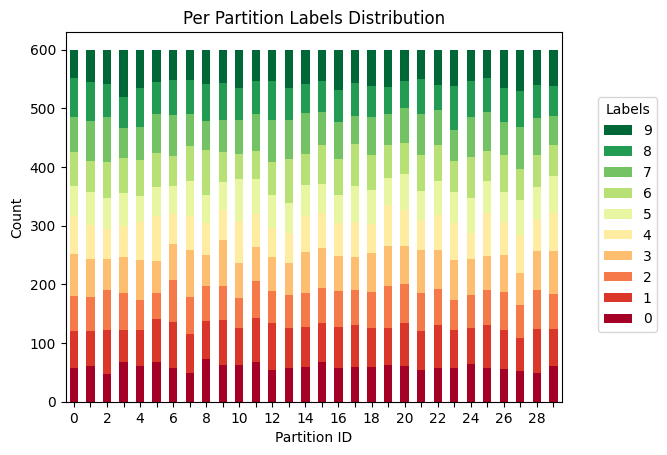

In [27]:
from flwr_datasets.visualization import plot_label_distributions

fig, ax, df = plot_label_distributions(
    partitioner,
    label_name="label",
    plot_type="bar",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=True,
    max_num_partitions=30,  # Note we are only showing the first 30 so the plot remains readable
    title="Per Partition Labels Distribution",
)

As you can see, the histogram of this partition is a bit different from the one we obtained at the beginning where we took the entire dataset into consideration. Because our data partitions are artificially constructed by sampling the MNIST dataset in an IID fashion, our Federated Learning example will not face sever _data heterogeneity_ issues (which is a fairly [active research topic](https://arxiv.org/abs/1912.04977)).

Let's next define how our FL clients will behave

## Defining a Flower `ClientApp`

You can think of a client in FL as an entity that owns some data and trains a model using this data. The caveat is that the model is being trained _collaboratively_ in Federation by multiple clients (sometimes up to hundreds of thousands) and, in most instances of FL, is sent by a central server running in a `ServerApp` (more on this later).

A Flower Client is a simple Python class with two distinct methods:

* `fit()`: With this method, the client does on-device training for a number of epochs using its own data. At the end, the resulting model is sent back to the server for aggregation.

* `evaluate()`: With this method, the server can evaluate the performance of the global model on the local validation set of a client. This can be used for instance when there is no centralised dataset on the server for validation/test. Also, this method can be use to asses the degree of personalisation of the model being federated.

This class will be then wrapped into a `ClientApp` that can be used to launch the simulation.

In [28]:
import tenseal as ts

def get_context():
    context = ts.context(
        ts.SCHEME_TYPE.CKKS,
        poly_modulus_degree=8192,
        coeff_mod_bit_sizes=[60, 40, 40, 60]
    )
    context.generate_galois_keys()
    context.global_scale = 2**40
    return context


Now let's define our Flower Client class:

In [29]:
from collections import OrderedDict
from typing import Dict, Tuple
import torch
from flwr.common import NDArrays, Scalar
from flwr.client import NumPyClient


class FlowerClient(NumPyClient):
    def __init__(self, trainloader, valloader) -> None:
        super().__init__()

        self.trainloader = trainloader
        self.valloader = valloader
        self.model = Net(num_classes=10)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def fit(self, parameters, config):
        """This method trains the model using the parameters sent by the
        server on the dataset of this client. At then end, the parameters
        of the locally trained model are communicated back to the server"""

        # copy parameters sent by the server into client's local model
        set_params(self.model, parameters)

        # Define the optimizer
        optim = torch.optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9)

        # do local training (call same function as centralised setting)
        train(self.model, self.trainloader, optim, self.device)

        # return the model parameters to the server as well as extra info (number of training examples in this case)
        return get_params(self.model), len(self.trainloader), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        """Evaluate the model sent by the server on this client's
        local validation set. Then return performance metrics."""

        set_params(self.model, parameters)
        # do local evaluation (call same function as centralised setting)
        loss, accuracy = test(self.model, self.valloader, self.device)
        # send statistics back to the server
        return float(loss), len(self.valloader), {"accuracy": accuracy}


# Two auxhiliary functions to set and extract parameters of a model

def set_params(model, parameters):
    params_dict = zip(model.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.from_numpy(v) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=True)

def get_params(model):
    return [val.cpu().numpy() for _, val in model.state_dict().items()]



Spend a few minutes to inspect the `FlowerClient` class above. Please ask questions if there is something unclear !

Then keen-eyed among you might have realised that if we were to fuse the client's `fit()` and `evaluate()` methods, we'll end up with essentially the same as in the `run_centralised()` function we used in the Centralised Training part of this tutorial. And it is true!! In Federated Learning, the way clients perform local training makes use of the same principles as more traditional centralised setup. The key difference is that the dataset now is much smaller and it's never _"seen"_ by the entity running the FL workload (i.e. the central server).


### The `client_fn` callback

Now let's see how the `FlowerClient` object above can be used in Flower: we need to construct a `ClientApp`. This can be conveniently be done by means of a `client_fn` callback that will return a `FlowerClient` that uses a specific data partition (`partition-id`). The index of the partition is set internally during the simulation (meaning you shouldn't worry about it this tutorial)

In [30]:
from flwr.common import Context
from flwr.client import ClientApp


def client_fn(context: Context):
    """Returns a FlowerClient containing its data partition."""

    partition_id = int(context.node_config["partition-id"])
    partition = fds.load_partition(partition_id, "train")
    # partition into train/validation
    partition_train_val = partition.train_test_split(test_size=0.1, seed=42)

    # Let's use the function defined earlier to construct the dataloaders
    # and apply the dataset transformations
    trainloader, testloader = get_mnist_dataloaders(partition_train_val, batch_size=32)

    return FlowerClient(trainloader=trainloader, valloader=testloader).to_client()


# Concstruct the ClientApp passing the client generation function
client_app = ClientApp(client_fn=client_fn)

Now that a `ClientApp` is fully defined, let's create its counterpart: the `ServerApp`.

In [31]:
import tenseal as ts
import tenseal as ts
import numpy as np
from tenseal.tensors.bfvvector import BFVVector

In [32]:
def context():
    context = ts.context(ts.SCHEME_TYPE.CKKS,8192, coeff_mod_bit_sizes=[60, 40, 40, 60])
    context.global_scale = pow(2, 40)
    context.generate_galois_keys()
    return context

context = context()

## Defining a Flower `ServerApp`

### Chosing a Flower Strategy


A strategy sits at the core of the Federated Learning experiment. It is involved in all stages of a FL pipeline: sampling clients; sending the _global model_ to the clients so they can do `fit()`; receive the updated models from the clients and **aggregate** these to construct a new _global model_; define and execute global or federated evaluation; and more.

Flower comes with [many strategies built-in](https://github.com/adap/flower/tree/main/src/py/flwr/server/strategy). For this tutorial, let's use what is arguable the most popular strategy out there: `FedAvg`.

The way `FedAvg` works is simple but performs surprisingly well in practice. It is therefore one good strategy to start your experimentation. `FedAvg`, as its name implies, derives a new version of the _global model_ by taking the average of all the models sent by clients participating in the round. You can read all the details [in the paper](https://arxiv.org/abs/1602.05629).

While Flower strategies offer a high degree of customization using callbacks, in this tutorial we'll focus on using just one: the `evaluate_metrics_aggregation_fn` callback. It allows you to pass a function that should be executed at the end of an _"evaluate"_ round (i.e. a round where clients evaluate the _global model_ they receive on their local data and report the result -- e.g. accuracy, loss, etc -- back to the server). For this tutorial we want to perform the weighted average of the _"accuracy"_ metrics returned by each `FlowerClient`'s `evaluate()` method:

In [33]:
from typing import List
from flwr.common import Metrics


# Define metric aggregation function
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

We'll use this callback when defining the strategy in the next section

### The `server_fn` callback

The easiest way to create a `ServerApp` with the aggregation _strategy_ of your choice is by means of a `server_fn` callback. It has a similar signature to `client_fn` but, instead of returning a client object, it returns all the components needed to run the server-side logic in Flower. In this tutorial we'll keep things simple and stick to `FedAvg` with initialised global parameters.

In [34]:
from flwr.common import ndarrays_to_parameters
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg

num_rounds = 5


def server_fn(context: Context):

    # instantiate the model
    model = Net(num_classes=10)
    ndarrays = get_params(model)
    # Convert model parameters to flwr.common.Parameters
    global_model_init = ndarrays_to_parameters(ndarrays)

    # Define the strategy
    strategy = FedAvg(
        fraction_fit=0.1,  # 10% clients sampled each round to do fit()
        fraction_evaluate=0.5,  # 50% clients sample each round to do evaluate()
        evaluate_metrics_aggregation_fn=weighted_average,  # callback defined earlier
        initial_parameters=global_model_init,  # initialised global model
    )

    # Construct ServerConfig
    config = ServerConfig(num_rounds=num_rounds)

    # Wrap everything into a `ServerAppComponents` object
    return ServerAppComponents(strategy=strategy, config=config)


# Create your ServerApp
server_app = ServerApp(server_fn=server_fn)

## Launching the Simulation

With both `ClientApp` and `ServerApp` ready, we can launch the simulation. Pass both apps to the `run_simulation()` function and specify the number of `supernodes` (this is a more general term used in Flower to refer to individual "nodes" or "clients"). We earlier partitioned the dataset into 100 partitions, one for each supernode. So we indicate that `num_supernodes`=100.

In [35]:
from flwr.simulation import run_simulation

run_simulation(
    server_app=server_app, client_app=client_app, num_supernodes=NUM_PARTITIONS
)

INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)
(raylet) /Users/creamy/Research/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
(raylet)   warnings.warn(
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 50 clients (out of 100)
INFO :      aggregate_evaluate: received 50 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)
INFO :      ag

Note above how the distributed `accuracy` goes up as training progresses while the loss goes down. Federated learning is working!

## Bonus: Create your own Strategy

Flower strategies can be extended easily to suit your FL setups or your preferred workflows whether you use Flower for research or in production. In this final section, you'll learn how to create a custom strategy that behaves just like `FedAvg` but extends the functionality of certain methods to achieve two things:
1. Save the results obtained on each round into a JSON file.
2. Create a plot at after the last round.


Let's call this strategy `FedAvgCustom`. We'll use it to also showcase how to use the `evaluate_fn` callback, a convenient way to do centralised evaluation of the global model after each round. Note this functionality is user-defined since it requires a choice in terms of ML-framework. (if you recall, Flower is framework agnostic).

> This being said, centralised evaluation of the global model is only possible if there exists a centralised dataset that somewhat follows a similar distribution as the data that's spread across clients. In some cases having such centralised dataset for validation is not possible, so the only solution is to federate the evaluation of the _global model_. This is the default behaviour in Flower. If you don't specify the `evaluate_fn` argument in your strategy, then, centralised global evaluation won't be performed.

In [36]:
from flwr.server.strategy import FedAvg
from flwr.common import Parameters
import json


class FedAvgCustom(FedAvg):
    def __init__(self, file_name: str, num_rounds: int, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.file_name = file_name
        self.num_rounds = num_rounds
        self.loss_list = []
        self.metrics_list = []

    def _make_plot(self):
        """Makes a plot with the results recorded"""
        round = list(range(1, len(self.loss_list) + 1))
        acc = [100.0 * metrics["accuracy"] for metrics in self.metrics_list]
        plt.plot(round, acc)
        plt.grid()
        plt.ylabel("Accuracy (%)")
        plt.xlabel("Round")

    def evaluate(self, server_round: int, parameters: Parameters):
        """Evaluate model parameters using an evaluation function."""
        loss, metrics = super().evaluate(server_round, parameters)
        # Record results
        self.loss_list.append(loss)
        self.metrics_list.append(metrics)
        # If last round, save results and make a plot
        if server_round == self.num_rounds:
            # Save to CSV
            with open(f"{self.file_name}.json", "w") as f:
                json.dump({"loss": self.loss_list, "metrics": self.metrics_list}, f)
            # Generate plot
            self._make_plot()


def get_evaluate_fn(testloader):
    """Return a function that can be called to do global evaluation."""

    def evaluate_fn(server_round: int, parameters, config):
        """Evaluate global model on the whole test set."""

        model = Net(num_classes=10)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model.to(device)

        # set parameters to the model
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)

        # call test (evaluate model as in centralised setting)
        loss, accuracy = test(model, testloader, device)
        return loss, {"accuracy": accuracy}

    return evaluate_fn

With the above defined, we just need to wrap it all up in a `ServerApp` as we did earlier but this time using the `FedAvgCustom` that we just defined.

In [37]:
from flwr.server import ServerApp, ServerConfig


def server_fn(context: Context):

    # instantiate the model
    model = Net(num_classes=10)
    ndarrays = get_params(model)
    # Convert model parameters to flwr.common.Parameters
    global_model_init = ndarrays_to_parameters(ndarrays)

    # Define the strategy
    strategy = FedAvgCustom(
        file_name="results_fedavgcustom",
        num_rounds=num_rounds,
        fraction_fit=0.1,  # 10% clients sampled each round to do fit()
        fraction_evaluate=0.25,  # 25% clients sample each round to do evaluate()
        evaluate_metrics_aggregation_fn=weighted_average,  # callback defined earlier
        initial_parameters=global_model_init,  # initialised global model
        evaluate_fn=get_evaluate_fn(
            testloader
        ),  # gloabl evaluation (here we can pass the same testset as used in centralised)
    )

    # Construct ServerConfig
    config = ServerConfig(num_rounds=num_rounds)

    # Wrap everything into a `ServerAppComponents` object
    return ServerAppComponents(strategy=strategy, config=config)


# Create your ServerApp
server_app = ServerApp(server_fn=server_fn)

All that is left is to launch the simulation. Note a plot will be displayed at the end and a `.json` with the results will be saved to the current directory.

INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)
(raylet) /Users/creamy/Research/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
(raylet)   warnings.warn(
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 25 clients (out of 100)
INFO :      aggregate_evaluate: received 25 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)
INFO :      ag

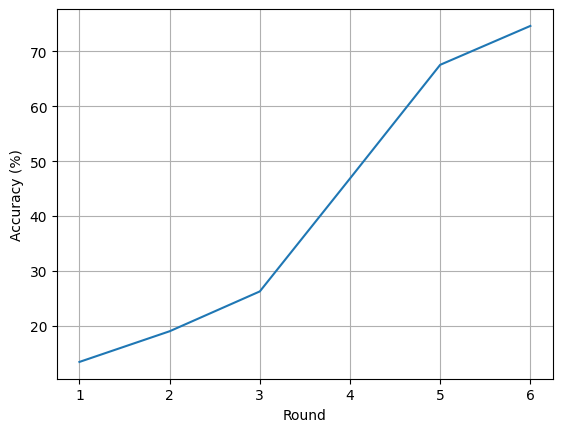

In [38]:
run_simulation(
    server_app=server_app, client_app=client_app, num_supernodes=NUM_PARTITIONS
)

## What's next?

Well, if you enjoyed this content, consider giving us a ⭐️ on GitHub -> https://github.com/adap/flower

* **[DOCS]** How about running your Flower clients on the GPU? find out how to do it in the [Flower Simulation Documentation](https://flower.ai/docs/framework/how-to-run-simulations.html)

* Check the quickstart tutorials in https://flower.ai/docs/framework/, for example:
    * [Quickstart PyTorch](https://flower.ai/docs/framework/tutorial-quickstart-pytorch.html)
    * [Quickstart TensorFlow](https://flower.ai/docs/framework/tutorial-quickstart-tensorflow.html)
    * [Quickstart JAX](https://flower.ai/docs/framework/tutorial-quickstart-jax.html)

* Most examples in the Flower Flower GitHub can run in simulation. These are some:

    * [Advanced PyTorch](https://github.com/adap/flower/tree/main/examples/advanced-pytorch)
    * [Finetuning a ViT](https://github.com/adap/flower/tree/main/examples/flowertune-vit)
    * [Quickstart with 🤗 Huggingface](https://github.com/adap/flower/tree/main/examples/quickstart-huggingface)
    * [Quickstart with XGBoost](https://github.com/adap/flower/tree/main/examples/xgboost-quickstart)
    * [Quickstart with MLX](https://github.com/adap/flower/tree/main/examples/quickstart-mlx)


* **[DOCS]** All Flower examples: https://flower.ai/docs/examples/

* **[VIDEO]** Our Youtube channel: https://www.youtube.com/@flowerlabs

Don't forget to join our Slack channel: https://flower.ai/join-slack/
